alpha, beta, K: 0.5 100 10


  7%|██▋                                     | 132/2000 [03:12<45:20,  1.46s/it]


Acc, nmi, adj: 0.34132933533233384 0.5068925236036115 0.29508164144957016
SIL: -0.037318785


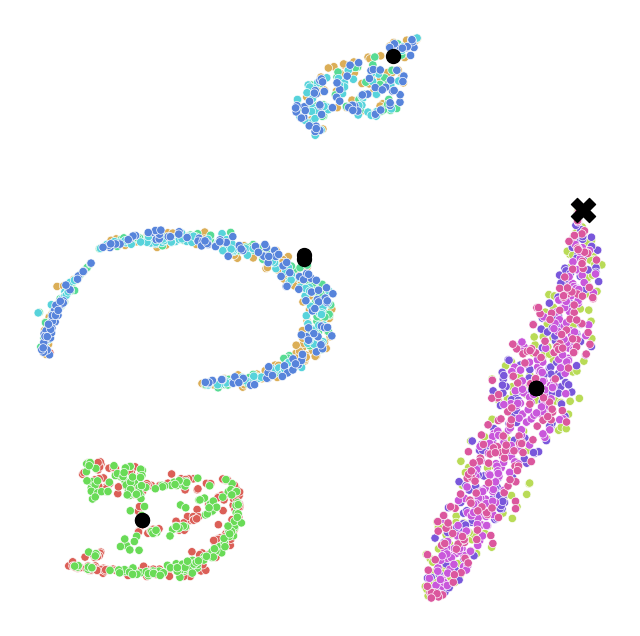

In [15]:
"Implementation based on https://github.com/PetarV-/DGI"

import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import itertools

from models import GIC, LogReg
from utils import process
from tqdm import tqdm
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
import statistics 
import argparse

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn import metrics
from munkres import Munkres, print_matrix
import numpy as np
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
from layers import GCN, AvgReadout, Discriminator, Discriminator_cluster, Clusterator

from sklearn.metrics import silhouette_score
import sklearn

class clustering_metrics():
    "from https://github.com/Ruiqi-Hu/ARGA"
    def __init__(self, true_label, predict_label):
        self.true_label = true_label
        self.pred_label = predict_label


    def clusteringAcc(self):
        # best mapping between true_label and predict label
        l1 = list(set(self.true_label))
        numclass1 = len(l1)

        l2 = list(set(self.pred_label))
        numclass2 = len(l2)
        if numclass1 != numclass2:
            print('Class Not equal, Error!!!!')
            return 0

        cost = np.zeros((numclass1, numclass2), dtype=int)
        for i, c1 in enumerate(l1):
            mps = [i1 for i1, e1 in enumerate(self.true_label) if e1 == c1]
            for j, c2 in enumerate(l2):
                mps_d = [i1 for i1 in mps if self.pred_label[i1] == c2]

                cost[i][j] = len(mps_d)

        # match two clustering results by Munkres algorithm
        m = Munkres()
        cost = cost.__neg__().tolist()

        indexes = m.compute(cost)

        # get the match results
        new_predict = np.zeros(len(self.pred_label))
        for i, c in enumerate(l1):
            # correponding label in l2:
            c2 = l2[indexes[i][1]]

            # ai is the index with label==c2 in the pred_label list
            ai = [ind for ind, elm in enumerate(self.pred_label) if elm == c2]
            new_predict[ai] = c

        acc = metrics.accuracy_score(self.true_label, new_predict)
        f1_macro = metrics.f1_score(self.true_label, new_predict, average='macro')
        precision_macro = metrics.precision_score(self.true_label, new_predict, average='macro')
        recall_macro = metrics.recall_score(self.true_label, new_predict, average='macro')
        f1_micro = metrics.f1_score(self.true_label, new_predict, average='micro')
        precision_micro = metrics.precision_score(self.true_label, new_predict, average='micro')
        recall_micro = metrics.recall_score(self.true_label, new_predict, average='micro')
        return acc, f1_macro, precision_macro, recall_macro, f1_micro, precision_micro, recall_micro

    def evaluationClusterModelFromLabel(self):
        nmi = metrics.normalized_mutual_info_score(self.true_label, self.pred_label)
        adjscore = metrics.adjusted_rand_score(self.true_label, self.pred_label)
        acc, f1_macro, precision_macro, recall_macro, f1_micro, precision_micro, recall_micro = self.clusteringAcc()

        
        return acc, nmi, adjscore


cuda0 = torch.cuda.is_available()#False

dataset = 'cora'

#num_clusters = 32
# training params
batch_size = 1
nb_epochs = 2000
patience = 20
lr = 0.001
l2_coef = 0.0
drop_prob = 0.0
hid_units = 64
sparse = True
nonlinearity = 'prelu' 
semantic_loss_ratio = 0.2
intra_loss_ratio = 0.5

intra_losses = []
inter_losses = []
topo_losses = []
all_losses = []
         
torch.cuda.empty_cache()


for m in range(1):
    
    
    adj, features, labels, idx_train, idx_val, idx_test = process.load_data(dataset)
    
    with open('our_data/adj_matrix.pkl', 'rb') as file:
        adj = pickle.load(file)

   

    with open('our_data/attributes_lil.pkl', 'rb') as file:
        features = pickle.load(file)


    with open('our_data/ground_truth_synthetic_10_clusters.pickle', 'rb') as file:
        labels_list = pickle.load(file)


    max_value = max(labels_list)
  

    # Convert the list to a one-hot encoding NumPy array
    labels = np.eye(max_value + 1)[labels_list]

    
    adj_sparse = adj
    
    ylabels = labels
    ylabelsx = np.where(labels == 1)[0]
    _, tsne_lab =  np.where(ylabels==1)
    
    
    features, _ = process.preprocess_features(features)


    nb_nodes = features.shape[0]
    ft_size = features.shape[1]
    nb_classes = labels.shape[1]

    adj = process.normalize_adj(adj + sp.eye(adj.shape[0]))

    if sparse:
        sp_adj = process.sparse_mx_to_torch_sparse_tensor(adj)
    else:
        adj = (adj + sp.eye(adj.shape[0])).todense()

    features = torch.FloatTensor(features[np.newaxis])
    if not sparse:
        adj = torch.FloatTensor(adj[np.newaxis])
    labels = torch.FloatTensor(labels[np.newaxis])
    #idx_train = torch.LongTensor(idx_train)
    #idx_val = torch.LongTensor(idx_val)
    #idx_test = torch.LongTensor(idx_test)

    if cuda0:
        #print('Using CUDA')
        features = features.cuda()
        if sparse:
            sp_adj = sp_adj.cuda()
        else:
            adj = adj.cuda()
        labels = labels.cuda()
        #idx_train = idx_train.cuda()
        #idx_val = idx_val.cuda()
        #idx_test = idx_test.cuda()

    b_xent = nn.BCEWithLogitsLoss()
    b_bce = nn.BCELoss()
    xent = nn.CrossEntropyLoss()
    cnt_wait = 0
    best = 1e9
    best_t = 0

    
    
    for alpha in [0.5] :
        for  beta in [100]:
            for num_clusters in [nb_classes]:
                
                print('alpha, beta, K:',alpha,beta, num_clusters)

                model = GIC(nb_nodes,ft_size, hid_units, nonlinearity, num_clusters, beta)
                optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)
                cnt_wait = 0
                best = 1e9
                best_t = 0
                if cuda0:
                #print('Using CUDA')
                    model.cuda()
                for epoch in tqdm(range(nb_epochs)):
                    model.train()
                    optimiser.zero_grad()

                    idx = np.random.permutation(nb_nodes)
                    shuf_fts = features[:, idx, :]

                    lbl_1 = torch.ones(batch_size, nb_nodes)
                    lbl_2 = torch.zeros(batch_size, nb_nodes)
                    lbl = torch.cat((lbl_1, lbl_2), 1)

                    

                    if cuda0:
                        shuf_fts = shuf_fts.cuda()
                        lbl = lbl.cuda()
                        

                    logits, logits2  = model(features, shuf_fts, sp_adj if sparse else adj, sparse, None, None, None, beta) 

                    topological_loss = alpha *b_xent(logits, lbl)  +  (1-alpha)*b_xent(logits2, lbl) 
                    
                    #I was a little unsure about this, but I created this function which doesn't detach the embeds. 
                    #Please check model.update_clusters()
                    ###################################
                    embeds, _,_,_ = model.update_clusters(features, sp_adj if sparse else adj, sparse, None, beta)
                    embs = embeds[0, :]
                    embs = embs / embs.norm(dim=1)[:, None]
                    
                    #Hard assignment
                    ###################################
                    clustering_output = model.cluster(embs, beta)
                    #print(f'here {type(predicted_labels[1])} {predicted_labels[1][0]} {torch.sum(predicted_labels[1][0])}')
                    clustering_logits =  clustering_output[1]
                    hard_cluster_assignment = torch.argmax(clustering_logits, dim=1)
                    
                    attributes = np.squeeze(features)
                    
                    indices_list = return_indices_per_cluster(hard_cluster_assignment)
                    loss_intra , selected_indices, selected_features = calculate_intra_cluster_loss(indices_list,\
                                                    attributes, hard_cluster_assignment, clustering_logits)
                    
                    #print(loss_intra)
                    loss_inter = calculate_inter_cluster_loss(selected_indices, attributes, clustering_logits
                                                             , selected_features, hard_cluster_assignment)
             
                    loss = (1-semantic_loss_ratio)*topological_loss + \
                    semantic_loss_ratio*(intra_loss_ratio*loss_intra + (1-intra_loss_ratio)*loss_inter) 
                    
                    #print(f'topo {topological_loss:0.3f} intra {loss_intra:.3f} inter {loss_inter:0.3f} whole {loss:0.3f}')
                    intra_losses.append(loss_intra.item())
                    inter_losses.append(loss_inter.item())
                    topo_losses.append(topological_loss.item())
                    all_losses.append(intra_losses[-1]+inter_losses[-1]+topo_losses[-1])
                    
                       
                    if loss < best:
                        best = loss
                        best_t = epoch
                        cnt_wait = 0
                        torch.save(model.state_dict(), dataset+'.pkl')

                        
                    else:
                        cnt_wait += 1

                    if cnt_wait == patience:
                        #print('Early stopping!')
                        break

                    loss.backward()
                    optimiser.step()

                    
                model.load_state_dict(torch.load(dataset+'.pkl'))

                
                embeds, H,c, Z= model.embed(features, sp_adj if sparse else adj, sparse, None, beta)
                embs = embeds[0, :]
                embs = embs / embs.norm(dim=1)[:, None]
                
                kmeans = KMeans(n_clusters=nb_classes,n_init='auto').fit(embs[ylabelsx].cpu().detach().numpy())
                predict_labels = kmeans.predict(embs[ylabelsx].cpu().detach().numpy())
            
                cm = clustering_metrics(tsne_lab, predict_labels)
                acc, nmi, adjscore = cm.evaluationClusterModelFromLabel()
                
                
                print('Acc, nmi, adj:', acc, nmi, adjscore)
                
                
                tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
                tsne_results = tsne.fit_transform(embs.cpu().detach().numpy())
                """
                plt.figure(figsize=(8,8))
                g = sns.scatterplot(
                    x=tsne_results[:,0], y=tsne_results[:,1],
                    hue=tsne_lab,
                    palette=sns.color_palette("hls", 7),
                    alpha=0.3,
                    legend=None
                )
                #g.set_ylim(-20,20)
                #g.set_xlim(-20,20)
                plt.axis('off')
                plt.show()
                
                """
                
                
                print('SIL:', silhouette_score(tsne_results[ylabelsx], tsne_lab))

                

                Z2 = torch.cat((c,Z),dim=0)
                H2 = torch.cat((embs,Z2),dim=0)
                tsne_lab2 = tsne_lab
                for _ in range(num_clusters+1):
                    tsne_lab2 = np.append(tsne_lab2, nb_classes)

                tsne = TSNE(n_components=2, perplexity=40, n_iter=1000)
                tsne_results = tsne.fit_transform(H2.cpu().detach().numpy())
                plt.figure(figsize=(8,8))
                g = sns.scatterplot(
                    x=tsne_results[:nb_nodes,0], y=tsne_results[:nb_nodes,1],
                    hue=tsne_lab,
                    palette=sns.color_palette("hls", nb_classes),
                    alpha=1,
                    legend=None
                )
                plt.scatter(x = tsne_results[nb_nodes:nb_nodes+1,0], y=tsne_results[nb_nodes:nb_nodes+1,1], s=300, marker='X', color='black')
                if (alpha != 1):
                    plt.scatter(x = tsne_results[nb_nodes+1:,0], y=tsne_results[nb_nodes+1:,1],s=100, color='black')
                #g.set_ylim(-20,20)
                #g.set_xlim(-20,20)
                plt.axis('off')
                plt.show()


# alpha, beta, K: 0.5 100 10   #SELECTED Normal
# Acc, nmi, adj: 0.3458270864567716 0.5164221761462122 0.28783159191381735


# alpha, beta, K: 0.75 100 6 ##SELECTED Normal
# Acc, nmi, adj: 0.624687656171914 0.6663330194717269 0.5446035104364456



#alpha, beta, K: 0.75 100 6  #Best pseudo edge
#Acc, nmi, adj: 0.5052473763118441 0.6347307932207867 0.4414735778161008


# alpha, beta, K: 0.25 10 10
# Acc, nmi, adj: 0.3363318340829585 0.472203972467893 0.24083550167400866

    
#     alpha, beta, K: 0.25 100 10
# Acc, nmi, adj: 0.3373313343328336 0.4723122844742844 0.24143715924231976

    
#     alpha, beta, K: 0.5 10 10
# Acc, nmi, adj: 0.33983008495752126 0.4727962516663139 0.24271777574119358

    
#     alpha, beta, K: 0.5 100 10
# Acc, nmi, adj: 0.33983008495752126 0.47461940114222234 0.24513535379597462

    
# alpha, beta, K: 0.75 10 10
# Acc, nmi, adj: 0.3378310844577711 0.47223213009267395 0.24146026171582502

    
#     alpha, beta, K: 0.75 100 10
# Acc, nmi, adj: 0.3423288355822089 0.4737176412958823 0.24360582011759813







# cosine(a,b)*p_1*p_2

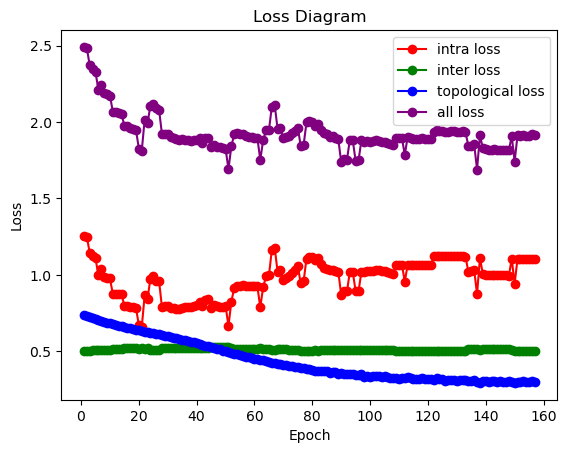

In [46]:
import matplotlib.pyplot as plt


x = list(range(1, len(all_losses) + 1))


# Plot connected dot diagram
plt.plot(x, intra_losses, marker='o', linestyle='-', color='r', label='intra loss')
plt.plot(x, inter_losses, marker='o', linestyle='-', color='g', label='inter loss')
plt.plot(x, topo_losses, marker='o', linestyle='-', color='b', label='topological loss')
plt.plot(x, all_losses, marker='o', linestyle='-', color='purple', label='all loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Diagram')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Soft clustering
#1-Sample some nodes
#2- Pairwise iteration, for each pair, and for each cluster combination, if i == j : -log(cosine)(p_i_1*p_j_2) else sigmoid(cosine)(p_i_1*p_j_2)

In [11]:
#Hard clustering

import numpy as np
from sklearn.metrics import pairwise_distances
import itertools
import random
from torchmetrics.functional.pairwise import pairwise_cosine_similarity


def return_indices_per_cluster(predict_labels):
    #Here I convert predicted labels to numpy. Maybe Torch is faster?
    arr = np.squeeze(predict_labels.detach().numpy())
    indices_list = [np.nonzero(arr == i)[0] for i in np.arange(nb_classes)]
    
    return indices_list

def calculate_intra_cluster_loss(indices_list, attribute_matrix, predicted_labels, 
                                 clustering_logits, presence_probability = 1):
    loss = torch.tensor(0.0, requires_grad=True)
    all_selected_indices = []
    all_selected_features = []
    
    for i in range(len(indices_list)):
        all_indices_for_cluster = indices_list[i]        
        num_elements_to_select = int(len(all_indices_for_cluster) * presence_probability)
        
        selected_indices_of_cluster = np.random.choice(all_indices_for_cluster, size=num_elements_to_select, replace=False)
        #print(selected_indices_of_cluster.shape, 'asdasd')
        
        if selected_indices_of_cluster.shape[0] < 2:
            #print(f'less than two elements selected from a cluster. Consider increasing the presence probability')
            continue
            
        selected_features = attribute_matrix[selected_indices_of_cluster]

        all_selected_indices.append(selected_indices_of_cluster)
        all_selected_features.append(selected_features)
            
        
       
        
        pairwise_similarities = pairwise_cosine_similarity(selected_features)
        
        

        selected_probabilities = clustering_logits[selected_indices_of_cluster]
        amax_probabilities = selected_probabilities[torch.arange(selected_indices_of_cluster.shape[0])
                                                    ,predicted_labels[selected_indices_of_cluster]]
        
        #Create a square torch tensor where the (i,j)th element is multiplication of the 
        #Amax probability of node(i) * Amax probability of node(j)
        
        product_tensor = torch.outer(amax_probabilities, amax_probabilities)
        #product_tensor.requires_grad_(amax_probabilities.requires_grad)
        
       

        
        #Weighted similarities multiplied by p_i_max * p_j_max
        weighted_similarities = pairwise_similarities * amax_probabilities
         
        #Exclude diagonal entries
        average_similarity = torch.sum(weighted_similarities)/(weighted_similarities.shape[0]**2 - weighted_similarities.shape[0])
        
        loss = loss - torch.log(average_similarity)
        
    return loss/len(indices_list), all_selected_indices, all_selected_features

def generate_pairs_with_probability(list1, list2, probability):
    all_pairs = list(itertools.product(list1, list2))
    num_pairs_to_select = int(len(all_pairs) * probability)
    selected_pairs = random.sample(all_pairs, num_pairs_to_select)

    return list(selected_pairs)


#Given that the calculate_intra_cluster_loss function gives us selected_indices and
# the corresponding list_of_selected_cluster_attributes, this function calculates the intra loss
def calculate_inter_cluster_loss(selected_indices, attribute_matrix,
                                 clustering_logits, list_of_selected_cluster_attributes, predicted_labels):
    loss = torch.tensor(0.0, requires_grad=True)
    counter = 1
    

    for first_index in range(len(selected_indices)):
        first_cluster = selected_indices[first_index]
        first_set_of_features = attribute_matrix[first_cluster]
        
                  
        selected_probabilities = clustering_logits[first_cluster]
        amax_probabilities_1 = selected_probabilities[torch.arange(first_cluster.shape[0])
                                                    ,predicted_labels[first_cluster]]
            

        for second_index in range(first_index):
            counter += 1
            
            second_cluster = selected_indices[second_index]
            second_set_of_features = attribute_matrix[second_cluster]
            
        
            pairwise_similarities = pairwise_cosine_similarity(first_set_of_features, second_set_of_features)
            
  
            
            selected_probabilities = clustering_logits[second_cluster]
            amax_probabilities_2 = selected_probabilities[torch.arange(second_cluster.shape[0])
                                                    ,predicted_labels[second_cluster]]
            
            
            #Again we calculate the recatngle amax probabilities multiplication by forming outer product
            product_tensor = torch.outer(amax_probabilities_1, amax_probabilities_2)
            weighted_similarity = pairwise_similarities * product_tensor    
            average_similarity = torch.mean(pairwise_similarities * product_tensor)
            added_loss =  torch.sigmoid(average_similarity)  #Torch.sigmoid
            loss = loss + added_loss 
    return loss/counter
        
        
# features = np.squeeze(features)

# indices_list = return_indices_per_cluster(predict_labels)
# loss_intra, selected_indices = calculate_intra_cluster_loss(indices_list, features)
# loss_inter = calculate_inter_cluster_loss(selected_indices, features, 0.1)


In [16]:
print(predict_labels)
print(type(predict_labels))

[7 7 2 ... 1 1 1]
<class 'numpy.ndarray'>


In [89]:
occurrences = {}
indices = {}

# Iterate through the array and count the occurrences
for i, label in enumerate(predict_labels):
    if label in occurrences:
        occurrences[label] += 1
        indices[label].append(i)
    else:
        occurrences[label] = 1
        indices[label] = [i]

# Print the occurrences
for label, count in occurrences.items():
    print(f"Label {label} occurs {count} times")
    

values = indices.values()
print()
features = np.squeeze(features)

for value in values:
    print(f'intra similarity {np.mean( 1-pairwise_distances(features[value], metric="cosine"))}')
    
print()

for i, value_1 in enumerate(values):
    for j in range(i):
        value_2 = list(values)[j]
        print(f'inter similarity {np.mean( 1-pairwise_distances(features[value_1], features[value_2] , metric="cosine"))}')


Label 2 occurs 426 times
Label 0 occurs 253 times
Label 6 occurs 294 times
Label 8 occurs 118 times
Label 3 occurs 80 times
Label 7 occurs 34 times
Label 4 occurs 11 times
Label 1 occurs 451 times
Label 9 occurs 296 times
Label 5 occurs 38 times

intra similarity 0.9925304055213928
intra similarity 0.9881664514541626
intra similarity 0.9924259185791016
intra similarity 0.992509126663208
intra similarity 0.9924865961074829
intra similarity 0.9928401708602905
intra similarity 0.9927597641944885
intra similarity 0.9926084876060486
intra similarity 0.9926269054412842
intra similarity 0.9925215840339661

inter similarity 0.498151034116745
inter similarity 0.4964190721511841
inter similarity 0.9902472496032715
inter similarity 0.49470895528793335
inter similarity 0.9902787208557129
inter similarity 0.9924365878105164
inter similarity 0.49373313784599304
inter similarity 0.9902104139328003
inter similarity 0.9923625588417053
inter similarity 0.9924055933952332
inter similarity 0.4961921274662

In [ ]:
print(np.amax(labels_list))

In [ ]:
print(predict_labels)

In [17]:
with open('GIC_k_10_clustering_result_Semantic.pickle', 'wb') as file:
    pickle.dump(predict_labels.tolist(), file)

In [ ]:
# with open('GIC_k_10_clustering_result.pickle', 'rb') as file:
#     loaded_array = pickle.load(file)

# print(loaded_array)

In [ ]:
with open('GIC_k_10_clustering_result.pickle', 'rb') as file:
#     loaded_array = pickle.load(file)

# print(loaded_array)print(labels_list)